In [18]:
# 导入所需的库
import numpy as np
import pandas as pd
import akshare as ak
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

# 设置画图参数
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

fund_code = '518880'

def get_fund_name_by_code(fund_code):
    # 获取所有基金的基本信息
    fund_info = ak.fund_name_em()
    
    # 根据基金代码筛选出基金名称
    fund_name = fund_info[fund_info['基金代码'] == fund_code]['基金简称'].values
    
    # 如果找到基金名称则返回，否则返回未找到的提示
    if len(fund_name) > 0:
        return fund_name[0]
    else:
        return "未找到该基金名称"

fund_name = get_fund_name_by_code(fund_code)
fund_price_name = fund_name + '价格'

print(fund_name)


华安黄金易ETF


In [17]:
print(get_fund_name_by_code('518880'))

华安黄金易ETF


In [ ]:
# 获取黄金ETF数据
# https://akshare.akfamily.xyz/data/fund/fund_public.html
etf_data = ak.fund_etf_hist_em(symbol='518880', period='daily', start_date='20130801', end_date='20250514')
Df = etf_data[['收盘']].rename(columns={'收盘': 'Close'})
Df.index = pd.to_datetime(etf_data['日期']).tolist()
Df = Df.dropna()

# 定义解释变量和因变量
Df['S1'] = Df['Close'].rolling(window=55).mean()
Df['S2'] = Df['Close'].rolling(window=60).mean()
Df['next_day_price'] = Df['Close'].shift(-1)
Df = Df.dropna()
X = Df[['S1', 'S2']]
y = Df['next_day_price']

# 划分训练集和测试集
t = int(0.8 * Df.shape[0])
X_train = X.iloc[:t]
y_train = y.iloc[:t]
X_test = X.iloc[t:]
y_test = y.iloc[t:]

# 创建并训练线性回归模型
linear = LinearRegression(fit_intercept=True).fit(X_train, y_train)
print(f'{taregt_price}(y) = %.2f * 55日移动平均线(x1) %+.2f * 60日移动平均线(x2) %+.2f (constant)' %
      (linear.coef_[0], linear.coef_[1], linear.intercept_))

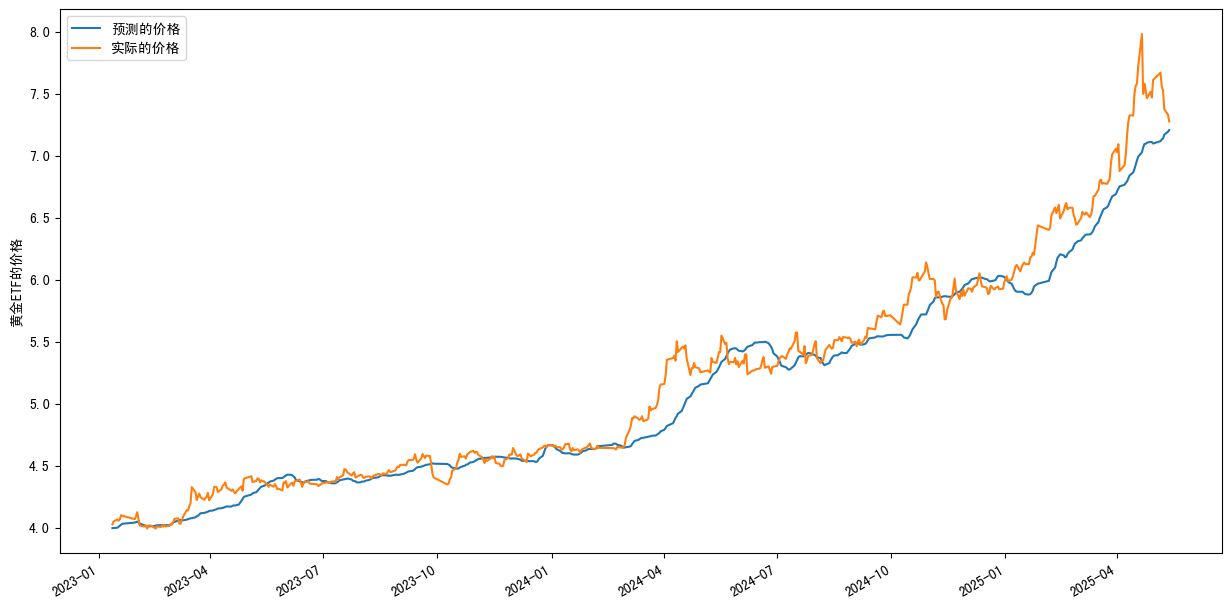

In [8]:

# 预测价格
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(15, 8))
y_test.plot()
plt.legend(['预测的价格', '实际的价格'])
plt.ylabel(f'{taregt_price}')
plt.show()



In [9]:
# 计算决定系数R2
r2_train = linear.score(X_train, y_train)
r2_test = linear.score(X_test, y_test)
print('训练集决定系数: %.4f' % r2_train)
print('测试集决定系数: %.4f' % r2_test)



训练集决定系数: 0.9753
测试集决定系数: 0.9567


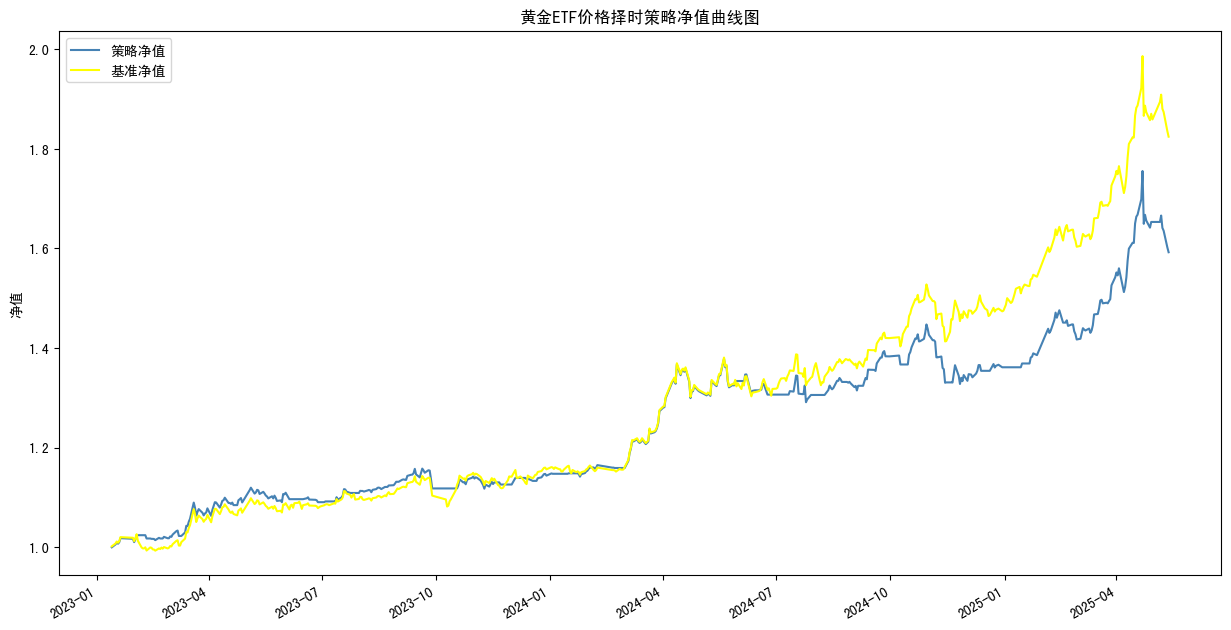

策略夏普率: 1.75
基准夏普率: 2.08


In [10]:
# 回测并绘制累积回报图
gold = pd.DataFrame()
gold['price'] = Df.iloc[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['gold_returns'] = gold['price'].pct_change()
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day, 1, 0)
gold['strategy_returns'] = gold['signal'].shift(1) * gold['gold_returns']
gold['strategy_nv'] = (gold['strategy_returns'] + 1).cumprod()
gold['bmk_nv'] = (gold['gold_returns'] + 1).cumprod()
gold[['strategy_nv', 'bmk_nv']].plot(figsize=(15, 8), color=['SteelBlue', 'Yellow'],
                                    title=f'{taregt_price}择时策略净值曲线图')
plt.legend(['策略净值', '基准净值'])
plt.ylabel('净值')
plt.show()

# 计算夏普率
strategy_sharpe = gold['strategy_returns'].mean() / gold['strategy_returns'].std() * (252**0.5)
bmk_sharpe = gold['gold_returns'].mean() / gold['gold_returns'].std() * (252**0.5)
print('策略夏普率: %.2f' % strategy_sharpe)
print('基准夏普率: %.2f' % bmk_sharpe)


In [11]:

# 每日滚动预测
current_date = datetime.now().strftime('%Y%m%d')
etf_data = ak.fund_etf_hist_em(symbol='518880', period='daily', start_date='20230101', end_date=current_date)
data = etf_data[['收盘']].rename(columns={'收盘': 'Close'})
data.index = pd.to_datetime(etf_data['日期']).tolist()
data['S1'] = data['Close'].rolling(window=55).mean()
data['S2'] = data['Close'].rolling(window=60).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S1', 'S2']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price, '买入', '空仓')
print(data.tail(1)[['signal', 'predicted_gold_price']].T)

                     2025-05-16
signal                       买入
predicted_gold_price   7.245407
